In [1]:
# Install tensorboard
import os

import torch.optim
!pip install tensorboard


if not os.path.exists('logs'):
    os.makedirs('logs')


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dataload import *
from lin_reg import *
from neural_net import *
import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2

In [3]:
dataset = dense_Dataset('data/embeddings.h5', 'data/densities.csv', test_perc=0.15, val_perc=0.15) 

In [24]:
h_params = {
    'input_size': 1024,
    'n_hidden': 512, 
    'batch_size': 128,
    'epochs':100,
    'lr': .001,
    'patience': 5
}

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Linear regression model
linear_regression = Lin_reg(h_params)
linear_regression.to(device)

# Linear regression model with Relu activation
# linear_regression_relu = Lin_reg_relu(h_params)
# linear_regression_relu.to(device)

# Neural network model

neural_net = NeuralNet(h_params)
neural_net.to(device)
model = neural_net

In [52]:
# actual training
losses_train = []
losses_val = []

train_keys, val_keys = dataset.train_keys, dataset.val_keys
print(f"Train keys: {len(train_keys)}, Val keys: {len(val_keys)}")


optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
# optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams['lr'])
criterion = nn.MSELoss()

# overfit on one sample
inputs, targets, _ = next(iter(Dataloader(dataset, train_keys, batch_size=5, shuffle=False)))
val_inputs, val_targets, _ = next(iter(Dataloader(dataset, val_keys, batch_size=5, shuffle=False)))
target_mean = targets.mean()
targets = targets - target_mean

val_mean = val_targets.mean()
val_targets = val_targets - val_mean


Train keys: 13033, Val keys: 2300


In [53]:
tmp_mean = None
for i in range(500):
    inputs, targets = inputs.to(model.device), targets.to(model.device)
    optimizer.zero_grad()
    outputs = model(inputs)
    outputs = outputs.view(-1)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    losses_train.append(loss.item())
    # do validation
    val_loss = 0.0
    with torch.no_grad():
        val_running_loss = 0.0
        # remove mean from targets
        val_inputs, val_targets = val_inputs.to(model.device), val_targets.to(model.device)
        val_outputs = model(val_inputs)
        val_outputs = val_outputs.view(-1)
        val_loss += criterion(val_outputs, val_targets).item()
        val_running_loss += val_loss
    losses_val.append(val_loss)
    
# print last 5 losses
print(losses_train[-5:])
print(losses_val[-5:])

[2.8552342428156408e-06, 2.846338702511275e-06, 2.837392003129935e-06, 2.8284975996939465e-06, 2.819781002472155e-06]
[0.0005132348742336035, 0.0005132494261488318, 0.0005132605438120663, 0.0005132705555297434, 0.0005132824881002307]


MSE: 2.8197807750984794e-06


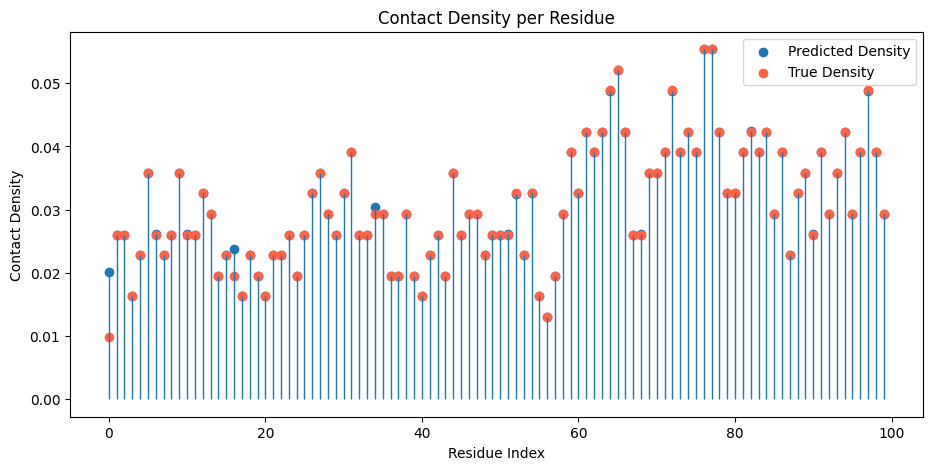

In [54]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
truths = truths + target_mean.item()
preds = preds + target_mean.item()
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
# plt.savefig("neural_net_density.png")
plt.show()

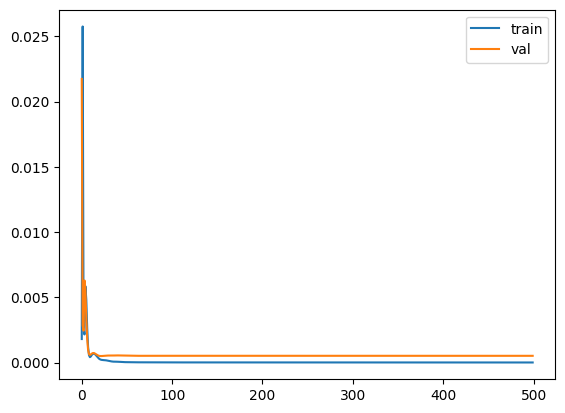

In [55]:
# plot the learning curve
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

In [26]:
# for tensorboard
path = "logs/protpred1"
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)

batch_size = h_params['batch_size']
epochs = h_params['epochs']
best_model = None
best_val_loss = float('inf')

losses_train = []
losses_val = []

train_loader = Dataloader(dataset, train_keys, batch_size=batch_size, shuffle=True)
val_loader = Dataloader(dataset, val_keys, batch_size=batch_size, shuffle=True)

early_stop = EarlyStopping(patience=h_params['patience'])


for epoch in range(epochs):
    model.train()  # training model
    running_loss = 0.0

    for inputs, targets, _ in tqdm.tqdm(train_loader, maxinterval=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}'):
        # send data to device
        inputs, targets = inputs.to(model.device), targets.to(model.device)
        targets = targets - targets.mean()
        # apply log(x+1) to targets
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.view(-1)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses_train.append(running_loss / len(train_loader))
    tb_logger.add_scalar('Training loss', running_loss / len(train_loader), epoch)

    model.eval()
    val_loss = 0.0
    target_mean = None
    output_mean = None
    with torch.no_grad():
        val_running_loss = 0.0
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(model.device), targets.to(model.device)
            target_mean = targets.mean()
            targets = targets - target_mean
            
            outputs = model(inputs)
            outputs = outputs.view(-1)
            
            output_mean = outputs.mean()
            
            val_loss += criterion(outputs, targets).item()

            val_running_loss += val_loss

    # remember validation scores
    losses_val.append(val_running_loss / len(val_loader))
    tb_logger.add_scalar('Validation loss', val_running_loss / len(val_loader), epoch)

    avg_val_loss = val_loss / len(val_loader)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model = model
    
    early_stop(losses_val[-1])
    if early_stop.should_stop():
        print(f"Stopped early at epoch: {epoch+1}")        
        break
    

print(f"Best validation loss: {best_val_loss}")

Epoch 7/100:  13%|█▎        | 13/102 [01:12<08:18,  5.60s/it]


KeyboardInterrupt: 

In [46]:
model.eval()
target_mean = None
output_mean = None
with torch.no_grad():
    val_running_loss = 0.0
    for inputs, targets, _ in val_loader:
        inputs, targets = inputs.to(model.device), targets.to(model.device)
        target_mean = targets.mean()
        targets = targets - target_mean
        
        outputs = model(inputs)
        outputs = outputs.view(-1)
        
        output_mean = outputs.mean()

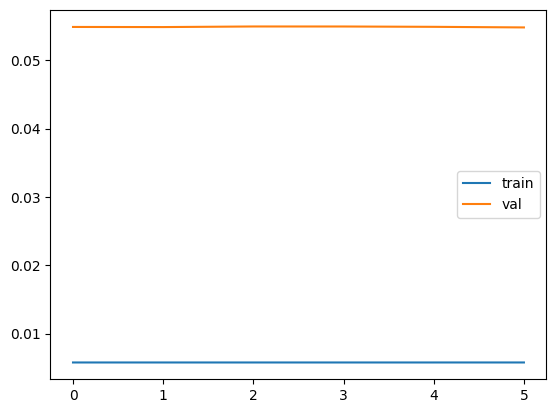

In [41]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

In [47]:
# print example outputs and targets
print(outputs[:10])
print(targets[:10])

# print means
print(target_mean, output_mean)

tensor([-0.0609, -0.0559, -0.1243, -0.1047, -0.1127, -0.0917, -0.0997, -0.0911,
        -0.0838, -0.0478], device='cuda:0')
tensor([-0.0056,  0.0034,  0.0210,  0.0210,  0.0297,  0.0210,  0.0297,  0.0254,
         0.0210,  0.0078], device='cuda:0')
tensor(0.0323, device='cuda:0') tensor(-0.0716, device='cuda:0')


In [48]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()
min(truths) + target_mean.item()

-0.0005338490009307861

MSE: 0.03178198263049126


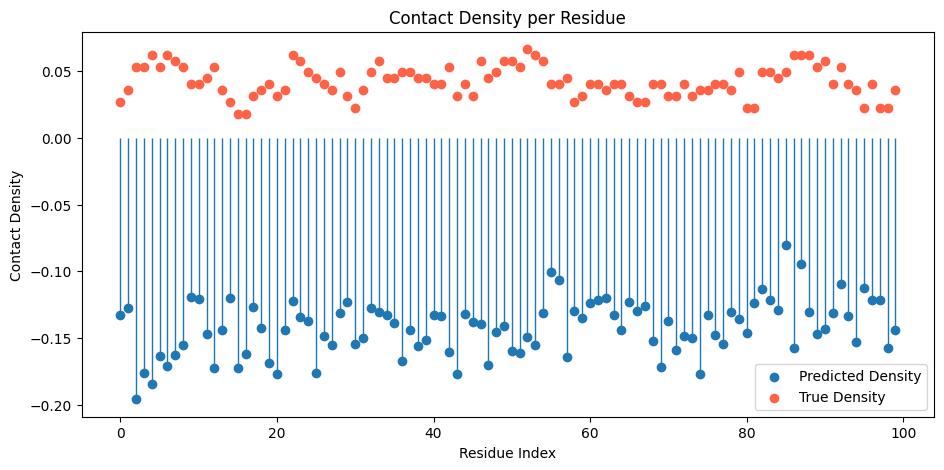

In [49]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
truths = truths + target_mean.item()
preds = preds + output_mean.item()
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.savefig("neural_net_big.png")
plt.show()


In [ ]:
# save the model checkpoint
torch.save(best_model.state_dict(), 'models/neural_net.pth')

In [13]:
# load a saved model
model = Lin_reg(hparams=h_params)
model.load_state_dict(torch.load('models/lin_reg_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Lin_reg(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [14]:
def predict(dataset, keys, model):
    batch_size = 32

    test_loader = Dataloader(dataset, keys, batch_size=batch_size, shuffle=False)
    model.eval()
    predictions = []
    truths = []
    pdb_chains = []
    with torch.no_grad():
        for inputs, targets, ids in tqdm.tqdm(test_loader, maxinterval=len(test_loader)):
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            predictions.append(outputs)
            truths.append(targets)
            pdb_chains.append(ids)

    return predictions, truths, pdb_chains


In [15]:
# predict on training and validation set
train_preds, train_truths, train_ids = predict(dataset, dataset.train_keys, model)
val_preds, val_truths, val_ids = predict(dataset, dataset.val_keys, model)

# calculate R2 score, Pearson correlation and MSE
train_r2, train_pearson, train_mse = evaluate(train_preds, train_truths)
val_r2, val_pearson, val_mse = evaluate(val_preds, val_truths)
print(f"Train R2: {train_r2}, Train Pearson: {train_pearson}, Train MSE: {train_mse}")
print(f"Val R2: {val_r2}, Val Pearson: {val_pearson}, Val MSE: {val_mse}")


100%|██████████| 72/72 [01:34<00:00,  1.32s/it]


Train R2: -0.25236785411834717, Train Pearson: PearsonRResult(statistic=0.09417471246051212, pvalue=0.0), Train MSE: 0.002168449107557535
Val R2: -0.2498471736907959, Val Pearson: PearsonRResult(statistic=0.09435643778427208, pvalue=0.0), Val MSE: 0.0021615454461425543


In [16]:
# save train preds and train truths to pickle
import pickle
# convert all tensors to numpy arrays
train_preds = [pred.cpu().numpy().flatten() for pred in train_preds]
train_truths = [truth.cpu().numpy() for truth in train_truths]
val_preds = [pred.cpu().numpy().flatten() for pred in val_preds]
val_truths = [truth.cpu().numpy() for truth in val_truths]

predictions = {'train_preds': train_preds, 'train_truths': train_truths, 'train_ids': train_ids,
               'val_preds': val_preds, 'val_truths': val_truths, 'val_ids': val_ids}
with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [13]:
# save losses to csv
import pandas as pd
losses = pd.DataFrame({'train': losses_train, 'val': losses_val})
losses.to_csv('losses.csv', index=False)

In [11]:
batch_size = h_params['batch_size']
train_keys, val_keys = dataset.train_keys, dataset.val_keys
train_loader = Dataloader(dataset, train_keys, batch_size=batch_size, shuffle=True)

for inputs, targets, ids in train_loader:
    print(inputs.shape)
    print(targets.shape)
    print(ids)
    break

torch.Size([34395, 1024])
torch.Size([34395])
['5G3TA', '1PJ5A', '6C9XA', '6Y32B', '7OD9C', '2IN3A', '6UXDA', '2D68A', '5X40A', '2A67A', '6J17A', '1QGKB', '3MX1A', '3FWKA', '2EX5A', '4R9FA', '5W0HA', '1XG5A', '6GSZA', '1VE4A', '8HTIR', '2FUJA', '6VJCA', '1NUUA', '3P02A', '2GB7A', '7ZNLA', '5IBWC', '5HKPC', '4TQ2A', '7VFQA', '2A9IA', '2RCCA', '5M1PA', '2X8KA', '4QVRA', '2C81A', '6L3RA', '2JE8A', '4MJGA', '1AKOA', '7VTBA', '8HCND', '4NZGA', '3P9VA', '1AE9A', '7EXXA', '3WLIA', '5SZCA', '3RNVA', '3NKEA', '2X8NA', '1YE8A', '6H8OA', '3CKDA', '6RPXA', '4EC6A', '8W9TA', '4LF0A', '4BG5A', '7ZHLA', '7L71A', '6H2RA', '6NQWA', '5YDUA', '8AVQA', '4WZSA', '7FJKA', '7USBA', '1WWMA', '1HTWA', '6PI6A', '2P14A', '7KQ5A', '1QHLA', '1JEKA', '1WMXA', '7EARA', '2N54A', '7BY3B', '1Q5DA', '4EICA', '1JUVA', '4GOSA', '8J7TA', '3H43A', '2GAKA', '2V3GA', '7R5ZA', '5YQ0A', '5KLAA', '2JMSA', '5Z2HA', '5CV0A', '3K13A', '2WW5A', '2QHQA', '3FN2A', '3SGGA', '3UGFA', '2J1DG', '3U6XS', '1YWYA', '2CCQA', '3BQPA', '3D1LA',